
# Временные ряды 4. Построение и оценка модели
##                                                              Обучаем и предсказываем



## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import warnings

In [12]:
warnings.filterwarnings("ignore") # отключает предупреждения

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [13]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

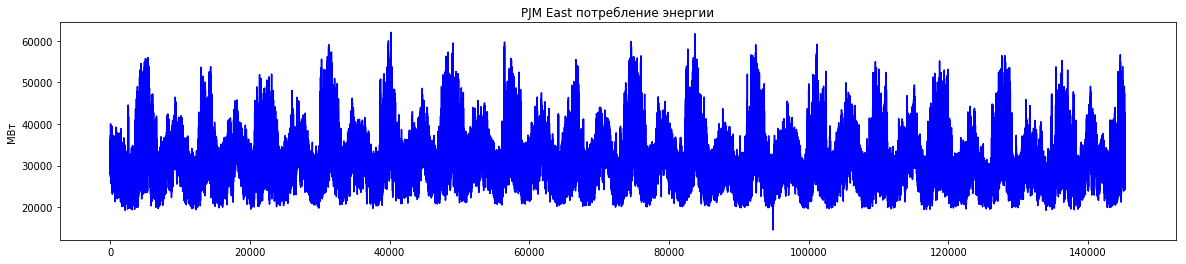

In [14]:
plt.figure(figsize =(20,4))
plt.plot(data['PJME_MW'].values[:-100], 'b' )  #.get_level_values('Date')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

## Генерация признаков

Построение признаков во временных рядах значительно зависит от семантики ряда и его проблемной области. Например, если мы пытаемся предсказывать биржевые показатели, то очевидно, что наш ряд зависит от календаря и внешних экономических причин (экзогенных факторов), которые никаким способом извлечь из самого ряда не выйдет. Другой случай, короткое предсказание аудиосигнала при обработке звука. Звук непрерывен и имеет выраженный периодический характер, что позволяет использовать новые признаки - коэффициенты спектрограмм или результаты вейвлет-анализа. Обычно, конечно , для звуковых рядов решают не задачу предсказания, а задачу оценки-классификации. Это еще один аспект анализа временных рядов, о котором поговорим в следующей теме. Однако, очевидно, что признаки, которые отлично сработают в одних рядах и задачах не сработают в других, внешне похожих, ситуациях. Будем рассматривать признаки влияние, которых на прогнозирование обычно положительно.

Первый слой таких признаков мы уже построили - это признаки из календаря, которые позволяют увязывать сезоны, дни недели и часы дня. Выберем в качестве горизонт прогнозирования ряда "Потребление энергии" - среднее потребление в день на 1 день вперед. Это подразумевает, что часовая точность ряда нам не нужна. Сделаем ресемплинг на дни


In [15]:
data_d = data.copy().resample('D').sum()
data_d.iloc[:,1:] = data_d.iloc[:,1:] // 24
data_d.drop(data.index[0],axis=0,inplace=True)
data_d.drop(data.index[-1],axis=0,inplace=True)
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-02,822277.0,2002,1,2,1,2,1,2,11,0,0,1
2002-01-03,828285.0,2002,1,3,1,3,1,3,11,0,0,0
2002-01-04,809171.0,2002,1,4,1,4,1,4,11,0,0,0
2002-01-05,729723.0,2002,1,5,1,5,1,5,11,0,0,0
2002-01-06,727766.0,2002,1,6,1,6,1,6,11,0,0,0


In [16]:
del data

Удалим данные о часах, т.к. они потеряли актуальность

In [17]:
data_d.drop('hour', axis=1,inplace=True)
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2002-01-02,822277.0,2002,1,2,1,2,1,2,0,0,1
2002-01-03,828285.0,2002,1,3,1,3,1,3,0,0,0
2002-01-04,809171.0,2002,1,4,1,4,1,4,0,0,0
2002-01-05,729723.0,2002,1,5,1,5,1,5,0,0,0
2002-01-06,727766.0,2002,1,6,1,6,1,6,0,0,0


Категорийные признаки ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek'] не стоит превращать в dummy-переменную, т.к. это приведет к значительному увеличению базы.



In [18]:
data_d.loc[data_d['PJME_MW'].isna() == 1 ,:].head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,


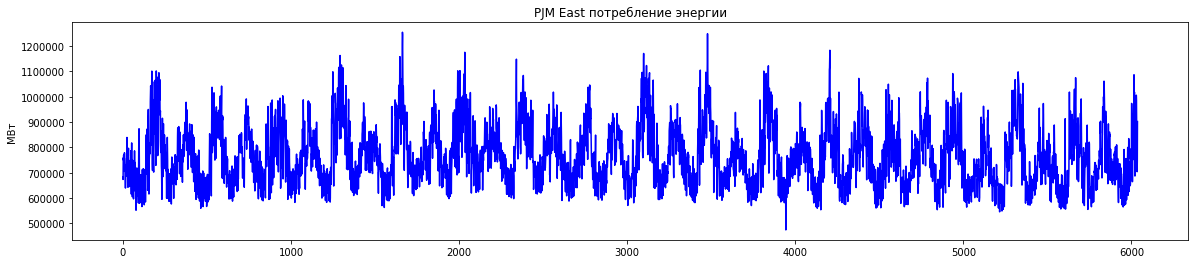

In [19]:
plt.figure(figsize =(20,4))
plt.plot(data_d['PJME_MW'].values[10:-10], 'b' )  #.get_level_values('Date')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Можно построить интегральный признак используя кластер-анализ или частичную классификацию. Начнем с признака по кластер-анализу. Воспользуемся методом kmeans, если можем предположить сколько будет кластеров, или DBSCAN, который не требует знания реального числа кластеров. 

In [20]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)
pca_ =PCA(n_components=2)

X = data_d.iloc[:,:].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)
X_p = pca_.fit_transform(Xscale)



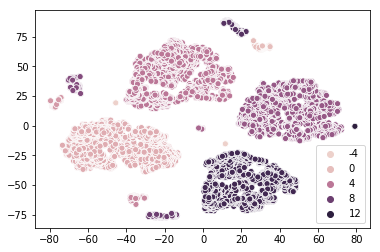

In [21]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

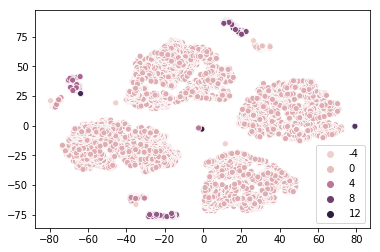

In [22]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

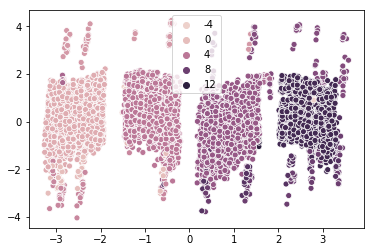

In [23]:
sns.scatterplot(X_p[:,0],X_p[:,1], hue=X_clast)
plt.show()

Рис.3. Результат кластер-анализа признаков

In [24]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  13
Число кластеров в календаре:  13


Вариант кластеризации с разметкой на рис.3 для случая масштабированных координат показывает отлично выделяемые кластеры с хорошим размещением объектов по группам. Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [25]:
data_d['day_week_month'] = X_clast
data_d.iloc[np.where(data_d['day_week_month']==0)[0]].iloc[:10,:]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,,
2002-01-02,822277.0,2002,1,2,1,2,1,2,0,0,1,0
2002-01-22,756951.0,2002,1,22,1,22,4,1,0,0,1,0
2002-02-19,747740.0,2002,2,19,1,50,8,1,0,0,1,0
2002-05-28,750204.0,2002,5,28,2,148,22,1,0,0,1,0
2003-01-02,770850.0,2003,1,2,1,2,1,3,0,0,1,0
2003-01-21,902195.0,2003,1,21,1,21,4,1,0,0,1,0
2003-02-18,825056.0,2003,2,18,1,49,8,1,0,0,1,0
2003-05-27,665287.0,2003,5,27,2,147,22,1,0,0,1,0
2004-01-02,717758.0,2004,1,2,1,2,1,4,0,0,1,0


В выборке объектов типа 0 собраны праздничные дни, а в типе 2 нового признака собрали субботы перед праздником:).

In [26]:
data_d.iloc[np.where(data_d['day_week_month']==2)[0]].iloc[:10,:]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,,
2002-01-20,707590.0,2002,1,20,1,20,3,6,0,1,0,2
2002-02-17,645198.0,2002,2,17,1,48,7,6,0,1,0,2
2002-05-26,584436.0,2002,5,26,2,146,21,6,0,1,0,2
2003-01-19,826314.0,2003,1,19,1,19,3,6,0,1,0,2
2003-02-16,862752.0,2003,2,16,1,47,7,6,0,1,0,2
2003-05-25,566925.0,2003,5,25,2,145,21,6,0,1,0,2
2003-08-31,676765.0,2003,8,31,3,243,35,6,0,1,0,2
2004-01-18,792631.0,2004,1,18,1,18,3,6,0,1,0,2
2004-02-15,748068.0,2004,2,15,1,46,7,6,0,1,0,2


Другой путь получения новых признаков применение преобразований для понижения размерности. Пример такого преобразования приведен выще в процессе построения признака из кластерного анализа , использовали редукцию пространства с использованием модели t-SNE. Однако, эта модель характерна высокой вычислительной сложностью, что увеличивает время решения задачи. Более простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу data_d.

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:-1])
Xpca.shape

(6057, 2)

In [28]:
data_d['pca1']=Xpca[:,0]
data_d['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [29]:
first_diff =np.array(data_d.iloc[1:,0].values - data_d.iloc[:-1,0].values).astype('float32') 
data_d['diff1'] = 0.0
data_d['diff1'] =  data_d['diff1'].astype('float') 
data_d['diff1'].values[1:] = first_diff

Вообще можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д. 

In [30]:
first_diff_d =(first_diff) / data_d.iloc[1:,0].values
data_d['diff1_d'] = 0.0
data_d['diff1_d'] =  data_d['diff1_d'].astype('float') 
data_d['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

Можно, например, взять Бокс-Кокс преобразование (тут не работает, т.к. дисперсия постоянна - нет смысла)

In [31]:
import scipy.stats as scs
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [32]:
first_diff_l =np.log(data_d.iloc[1:,0].values) 
#first_diff_l, lmbda1 = scs.boxcox(data_d.iloc[1:,0].values) # НЕ РАБОТАЕТ , когда АРГУМЕНТ ЛОГАРИФМА БЛИЗОК 0 
data_d['diff1_l'] = 0
data_d['diff1_l'] =  data_d['diff1_l'].astype('float') 
data_d['diff1_l'].values[1:] = first_diff_l

Добавим скользящее среднее по всей модели с глубиной 7 дней. Размер окна определен длиной недельных циклов.

In [33]:
data_d['d_w7']=data_d['PJME_MW'].rolling(window=7).mean()

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [34]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_d['exp_0_05'] = exponential_smoothing(data_d['PJME_MW'], 0.05)


В итоге данные примут вид 

In [35]:
data_d.iloc[10:15,:]


,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month,pca1,pca2,diff1,diff1_d,diff1_l,d_w7,exp_0_05
Date,,,,,,,,,,,,,,,,,,,
2002-01-12,683205.0,2002,1,12,1,12,2,5,0,0,0,1,-3.081700,-0.758427,-59536.0,-0.087142,13.434550,763482.714286,800311.343513
2002-01-13,673268.0,2002,1,13,1,13,2,6,0,0,0,1,-3.073762,-1.106887,-9937.0,-0.014759,13.419899,755697.285714,793959.176337
2002-01-14,758471.0,2002,1,14,1,14,3,0,0,0,0,1,-3.029531,0.930862,85203.0,0.112335,13.539060,749762.857143,792184.767521
2002-01-15,749371.0,2002,1,15,1,15,3,1,0,0,0,1,-3.021593,0.582402,-9100.0,-0.012144,13.526989,739000.142857,790044.079145
2002-01-16,768234.0,2002,1,16,1,16,3,2,0,0,0,1,-3.013656,0.233942,18863.0,0.024554,13.551850,732943.857143,788953.575187


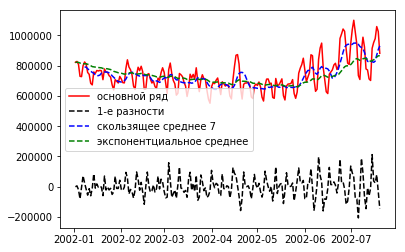

In [36]:
N100=200
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_d.index[:N100],data_d['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_d.index[:N100],data_d['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


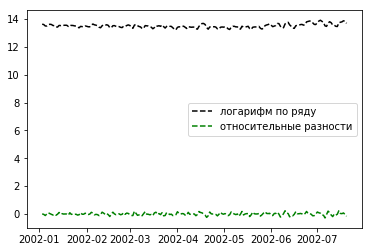

In [37]:
N100=200
plt.plot(data_d.index[1:N100],data_d['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_d.index[1:N100],data_d['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

Проблема состоит в том, что подобных признаков можно построить бесконечное количество. Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 13 недель и недельный цикл по дням. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспоненциальных средних в диапазоне alpha = [0.3, 0.8] 

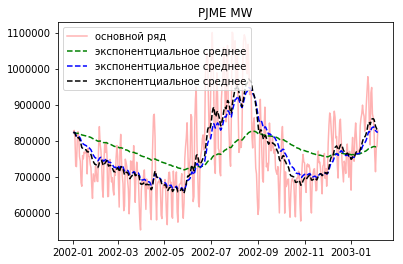

In [38]:
data_d['exp_0_01'] = exponential_smoothing(data_d['PJME_MW'], 0.01)
data_d['exp_0_03'] = exponential_smoothing(data_d['PJME_MW'], 0.03)
data_d['exp_0_04'] = exponential_smoothing(data_d['PJME_MW'], 0.04)
data_d['exp_0_06'] = exponential_smoothing(data_d['PJME_MW'], 0.06)
data_d['exp_0_07'] = exponential_smoothing(data_d['PJME_MW'], 0.07)
data_d['exp_0_08'] = exponential_smoothing(data_d['PJME_MW'], 0.08)

N100=400
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_d.index[:N100],data_d['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [39]:
data_d.iloc[:7,14]=0

Добавим истории длиной p в признаках автокорреляции

In [40]:
p = 14
for i in range(p):
    data_d['t'+str(p-i)]=0
    data_d['t'+str(p-i)].values[p:] = data_d['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [41]:
p = 14
for i in range(p):
    data_d['d'+str(p-i)]=0
    data_d['d'+str(p-i)].values[p:] = data_d['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [42]:
data_d.head(20)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,822277.0,2002,1,2,1,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-03,828285.0,2002,1,3,1,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-04,809171.0,2002,1,4,1,4,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-05,729723.0,2002,1,5,1,5,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-06,727766.0,2002,1,6,1,6,1,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-07,800012.0,2002,1,7,1,7,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-08,824710.0,2002,1,8,1,8,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-09,810628.0,2002,1,9,1,9,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-10,755317.0,2002,1,10,1,10,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [43]:
scl_target=StandardScaler() 
# p = 14
h=1
target = data_d['PJME_MW'].values[h+p:].reshape((data_d.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(6042, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [44]:
scl_x=StandardScaler() 

X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(6042, 53)

In [45]:
X[:7,14]=0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [46]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=1.00,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.01,  I=7
F-test=0.00,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.00,  I=12
F-test=0.01,  I=13
F-test=0.05,  I=14
F-test=0.05,  I=15
F-test=0.95,  I=16
F-test=0.46,  I=17
F-test=0.24,  I=18
F-test=0.03,  I=19
F-test=0.13,  I=20
F-test=0.19,  I=21
F-test=0.29,  I=22
F-test=0.32,  I=23
F-test=0.35,  I=24
F-test=0.13,  I=25
F-test=0.19,  I=26
F-test=0.15,  I=27
F-test=0.10,  I=28
F-test=0.10,  I=29
F-test=0.10,  I=30
F-test=0.12,  I=31
F-test=0.19,  I=32
F-test=0.27,  I=33
F-test=0.21,  I=34
F-test=0.15,  I=35
F-test=0.15,  I=36
F-test=0.18,  I=37
F-test=0.29,  I=38
F-test=0.01,  I=39
F-test=0.01,  I=40
F-test=0.00,  I=41
F-test=0.01,  I=42
F-test=0.00,  I=43
F-test=0.00,  I=44
F-test=0.00,  I=45
F-test=0.01,  I=46
F-test=0.01,  I=47
F-test=0.00,  I=48
F-test=0.01,  I=49
F-test=0.00,  I=50
F-test=0.00,  I=51
F-test=0.01,  I=52


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки  от 14 до 21. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [47]:
sfk =SelectKBest(f_regression, k=7)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(6042, 7)

In [48]:
column_names = data_d.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_06', 'exp_0_07', 'exp_0_08', 't1'], dtype='object')

In [49]:
X_new1[295:300,:]

array([[-0.33238888, -0.27749004, -0.58076296, -0.83556721, -0.82440965,
        -0.80501657, -0.37615206],
       [-0.44539557, -0.40051822, -0.60797969, -0.82390515, -0.81011245,
        -0.78902962, -0.33216955],
       [-1.23931844, -1.33161102, -0.68119908, -0.88176795, -0.87445975,
        -0.86089165, -0.44519768],
       [-1.51638945, -1.68800329, -0.76667249, -0.96017825, -0.96139959,
        -0.95721676, -1.23927113],
       [-0.72508515, -0.71462423, -0.83120558, -0.96528581, -0.96486605,
        -0.95955139, -1.5163947 ]])

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [50]:
sfp=SelectPercentile(f_regression, percentile=20)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(6042, 11)

In [51]:
column_namesp = data_d.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_05', 'exp_0_06', 'exp_0_07',
       'exp_0_08', 't13', 't6', 't5', 't1'],
      dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [52]:

gr_model = GradientBoostingRegressor(max_depth=5, n_estimators=10).fit(X, y.ravel())


sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(6042, 5)

Сравним результаты:


In [53]:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[-0.85181491, -0.86171382, -0.382952  , -0.07826677, -0.13651819,
         -0.18319714, -0.4027067 ],
        [-1.15668712, -1.22873614, -0.48468941, -0.17370457, -0.23993595,
         -0.29451558, -0.85169411],
        [-0.55118568, -0.51767848, -0.5903621 , -0.21092521, -0.27689792,
         -0.33090415, -1.15662414],
        [-0.64910233, -0.62789078, -0.68041322, -0.254401  , -0.32084856,
         -0.37505855, -0.55100785],
        [-0.7456875 , -0.73832753, -0.78509685, -0.30364121, -0.37116845,
         -0.42621233, -0.64894307]]),
 array([[-0.85181491, -0.86171382, -0.382952  , -0.00337631, -0.07826677,
         -0.13651819, -0.18319714, -0.85590033, -0.55132629,  0.07747272,
         -0.4027067 ],
        [-1.15668712, -1.22873614, -0.48468941, -0.09076626, -0.17370457,
         -0.23993595, -0.29451558, -0.09904256,  0.07772052, -0.11327994,
         -0.85169411],
        [-0.55118568, -0.51767848, -0.5903621 , -0.12788536, -0.21092521,
         -0.27689792, -0.3309041

In [54]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 16 17 22 23 24 38]
Номера признаков лучших признаков по процентной форме:  [ 0 16 17 18 22 23 24 26 33 34 38]
Номера признаков для выбора по модели :  [ 0  7 13 16 33]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,13,16,11,24,23, ...] признаки и перейдем к построению модели.

In [55]:
list_par=[0,7,13,17,16,18,22,23,24,33,38]
X_new = X[:,list_par]
data_d.columns[list_par]

Index(['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_05',
       'exp_0_06', 'exp_0_07', 'exp_0_08', 't6', 't1'],
      dtype='object')

In [56]:
from sklearn.linear_model import LinearRegression 


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [57]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

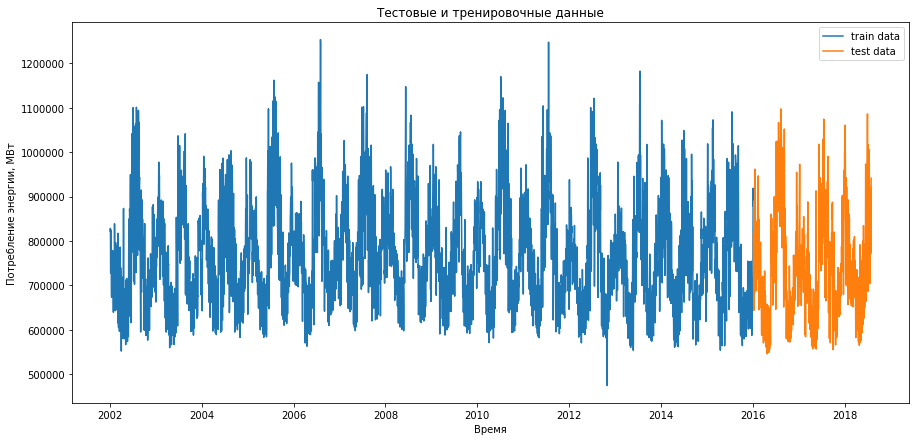

In [58]:
train, test = split_data( data_d.iloc[:-1,:], '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [59]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:-1,:]
y_test =y[train.shape[0]:-1,0]

In [60]:
train.shape

(5118, 53)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

In [62]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [63]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [64]:
X_test.shape

(923, 11)

In [65]:
y_test_pred_g = model_g.predict(X_test)

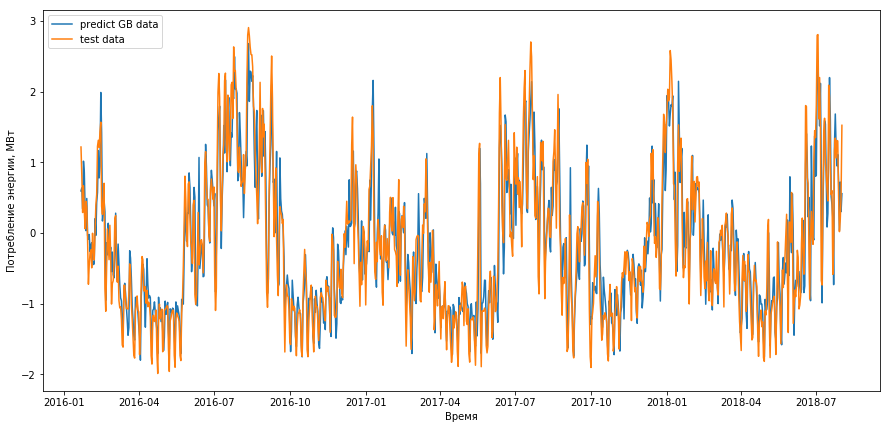

In [66]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [68]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.16879373006697238 
ошибка mae  :   0.3143821342261293 
оценка R2 :   0.8368152804442078


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Пожэтому переведем ответ решателя обратно в состояние без масштаба.

In [69]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.6948893145942705 %


Анализ на отсутствие корреляции с последующим ответом (проверяем не делаем ли предсказание в стиле "завтра==сегодня")

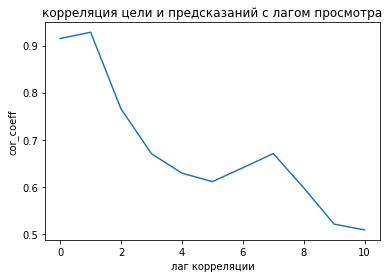

In [71]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Поскольку самое большое значение корреляции не с первым ответом, то не все хорошо. Однако корреляция при лаге 1 меньше 1, а это уже неплохо. 

Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и тем неменее пока точность предсказания не превышает 95%. 
Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Выбираем модель с рангом 1. {'n_estimators': 1200, 'max_depth': 2} (в одном из запусков RandomizedSearchCV был лучший резльтат) и проведем ее обучение на тренировочном наборе.

In [72]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=1200)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.63269615146911 %


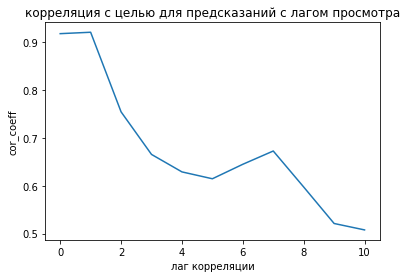

In [73]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью для предсказаний с лагом просмотра')
plt.show()

По корреляциям результат не идеальный , но приемлемый.
Качество решения задачи по MAPE повысилось почти на 0.03%. Очевидно, что диапазон вариаций значений был довольно узким и есть возможность поискать решение в более широком выборе параметров и их значений. Кроме того, провели всего 10 итераций поиска, что также не позволяет гарантировать идеальный ответ. Однако даже в такой версии за несколько минут поиска удается улучшить результат исходной модели. 

## Сохраниение модели

In [74]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


In [75]:
scl_target.scale_[0] , scl_target.mean_[0]

(112680.94564704997, 769833.069347898)

In [76]:
scl_x.scale_[0] , scl_x.mean_[0]

(112657.04021275892, 769802.9470374049)

## Использование модели для предсказания n*h моментов времени

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем 10 дней прогноза.

In [77]:
X_test_100 = X_test.copy()

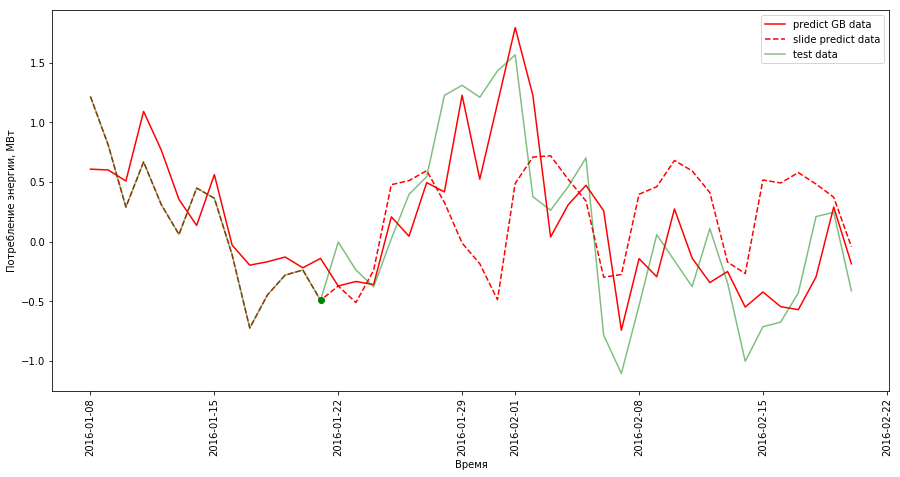

In [78]:
# ['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07','exp_0_08', 't6', 't1']
#['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07', 'exp_0_08']
# 12/06
# ['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07','exp_0_08', 't13', 't6', 't1'] 
# 5/11
#['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_05','exp_0_06', 'exp_0_07', 'exp_0_08', 't6', 't1']
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 30+p
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'exp_0_07', 'exp_0_08'
    X_test_100[i+1,6] = X_test_100[i,6]*(1-0.06)+ 0.06 * X_test_100[i+1,0] 
    X_test_100[i+1,5] = X_test_100[i,5]*(1-0.05)+ 0.05 * X_test_100[i+1,0] 
    X_test_100[i+1,7] = X_test_100[i,7]*(1-0.07)+ 0.07 * X_test_100[i+1,0]
    X_test_100[i+1,8] = X_test_100[i,8]*(1-0.08)+ 0.08 * X_test_100[i+1,0]
    #строим 'd_w7' - признак под номером 3
    X_test_100[i+1,3] = np.mean(X_test_100[i-6:i+1,0]) 
    #строим 'diff1_l' - признак под номером 4
    # строим логарифм по значению ряда и скалируем признак по схеме 16-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[16])*scl_x.scale_[16]
    #устанавливаем новое значение для 4
    X_test_100[i+1,4] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,9] = X_test_100[i-6,0]
    
    X_test_100[i+1,10] = X_test_100[i-1,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.xticks(rotation='90')
plt.legend()
plt.show()    

In [79]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:N10]),y_pred = scl_target.inverse_transform( y_test_100[p:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   9.174955416161241 %


Ошибка прогнозирования выросла до 9%. Однако, мы предсказываем на 10 дней вперед, что само по себе достаточно сложно для любой модели. Промах нарастает с глубиной предсказания. Однако, тенденция прослеживается и на горизонте 10 дней вперед. Таким образом, построили модель однодневных прогнозов и протянули ее на более длинный интервал за счет авторекурсивного обращения к значениям ряда. В простом алгоритме рекурсии следует учесть и изменение скользящих средних, которые не обработаны сейчас. Это потребует обновления не только признака X[:,0], но и признаков 3 и 4, 5, 6 финальной модели ('diff1_l', 'd_w7', 'exp_0_07',  'exp_0_08'). Это конечно требует некоторых усилий при организации обработки, но можно получить неплохой результат на довольно длинном периоде прогнозирования. Помимо этого, мы построим прогноз для каждой точки ряда, а не только для точки h на глубине прогнозирования.

## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Используем авторекурсивную модель.



## Задание


1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.
